# A simple 2D Flow Matching model

This notebook trains and evaluates a simple 2D FM model with CondOT (i.e., linear) scheduler.

Dataset: 2D checkerboard
Model (velocity): MLP

## Imports and init device

In [37]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

from peft import LoraConfig, get_peft_model
from sklearn.datasets import make_moons


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [38]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [39]:
torch.manual_seed(42)

## Dataset

In [ ]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)

    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45
    
    return data.float()
def train_moon_gen(batch_size: int = 200, device: str = "cpu", is_pretrain: bool = False):
    full_x, full_y = make_moons(n_samples=batch_size * 2, noise=0, random_state=42)
    if is_pretrain:
        return full_x[:batch_size], full_y[:batch_size]
    else:
        data = full_x[full_y == 1][:batch_size]
    return data

## Model

In [ ]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

## Train Velocity Flow Matching model

In [42]:
# training arguments
lr = 0.001
batch_size = 4096
iterations = 20001
print_every = 2000 
hidden_dim = 512
pre_train = False

# velocity field model init
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())
if not pre_train:
    state_dict = torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/pretrain_weights_noise0/raw_model_19999.pth", map_location=device)
    vf.load_state_dict(state_dict)
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["main.0", "main.2", "main.4", "main.6"],  # target Linear layers in MLP
        init_lora_weights="gaussian",
    )
    vf = get_peft_model(vf, lora_config)
    # init optimizer (only optimize LoRA parameters)
    optim = torch.optim.Adam(vf.parameters(), lr=lr)
    optim.param_groups[0]['params'] = [p for n, p in vf.named_parameters() if 'lora_' in n]
    iterations = 10000  # set iterations to 10000 for LoRA training
else:
    # init optimizer (optimize all parameters)
    optim = torch.optim.Adam(vf.parameters(), lr=lr)


# train
start_time = time.time()
loss_history = []
for i in range(iterations):
    optim.zero_grad() 
    
    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    x_1 = inf_train_gen(batch_size=batch_size, device=device) # sample data
    # x_0 = torch.randn_like(x_1).to(device)

    x_0, y = make_moons(n_samples=x_1.shape[0] * 3, noise=0.5, random_state=42)
    if pre_train:
        x_0 = torch.tensor(x_0[y == 0][:x_1.shape[0]]).float().to(device)  # use only one class for pre-training
    else:
        x_0 = torch.tensor(x_0[y == 1][:x_1.shape[0]]).float().to(device)

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device)
    

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    loss = torch.pow(vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
    loss_history.append(loss.item())
    # optimizer step
    loss.backward() # backward
    optim.step() # update
    
    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
              .format(i+1, elapsed*1000/print_every, loss.item())) 
        start_time = time.time()
        if not pre_train:
            vf.save_pretrained(f"/home/u5649209/workspace/flow_matching/ckpts/pretrain_weights_noise0.5/lora_weights_{i+1}")
        else:
            torch.save(vf.state_dict(), f"/home/u5649209/workspace/flow_matching/ckpts/pretrain_weights_noise0/raw_model_{i}.pth")


| iter   2000 |  7.80 ms/step | loss    2.740 
| iter   4000 |  6.23 ms/step | loss    2.715 
| iter   6000 |  7.33 ms/step | loss    2.617 
| iter   8000 |  5.90 ms/step | loss    2.831 
| iter  10000 |  7.79 ms/step | loss    2.786 


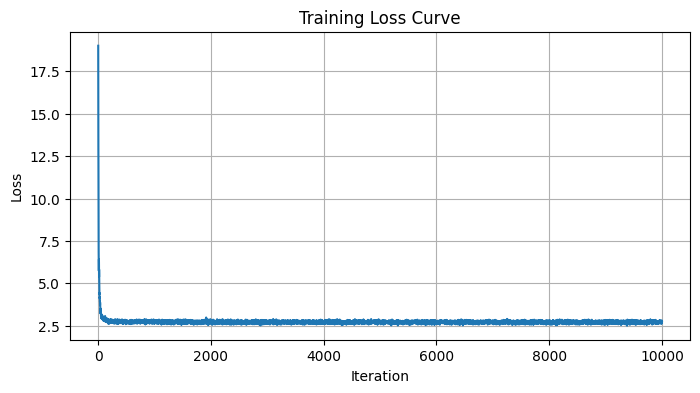

In [43]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history[:])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

#### Sample from trained model

In [44]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [45]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

### Visualize the path

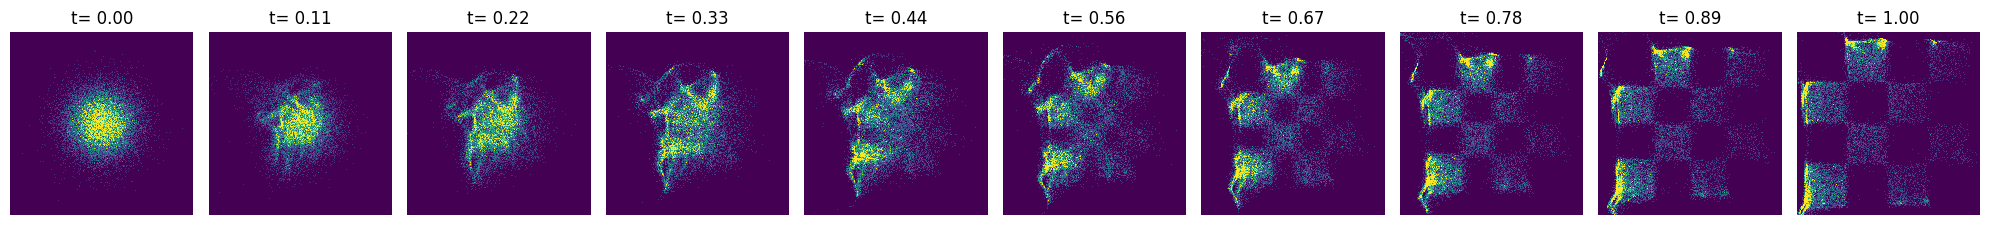

In [46]:
sol = sol.cpu().numpy()
T = T.cpu()

fig, axs = plt.subplots(1, 10,figsize=(20,20))

for i in range(10):
    H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

## Compute and Visualize Model Log-likelihood

In [47]:
from torch.distributions import Independent, Normal

In [48]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

grid_size = 200
x_1 = torch.meshgrid(torch.linspace(-5, 5, grid_size), torch.linspace(-5, 5, grid_size))
x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)

In [49]:
# source distribution is an isotropic gaussian
gaussian_log_density = Independent(Normal(torch.zeros(2, device=device), torch.ones(2, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p

log_p_acc /= num_acc

# compute with exact divergence
_, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

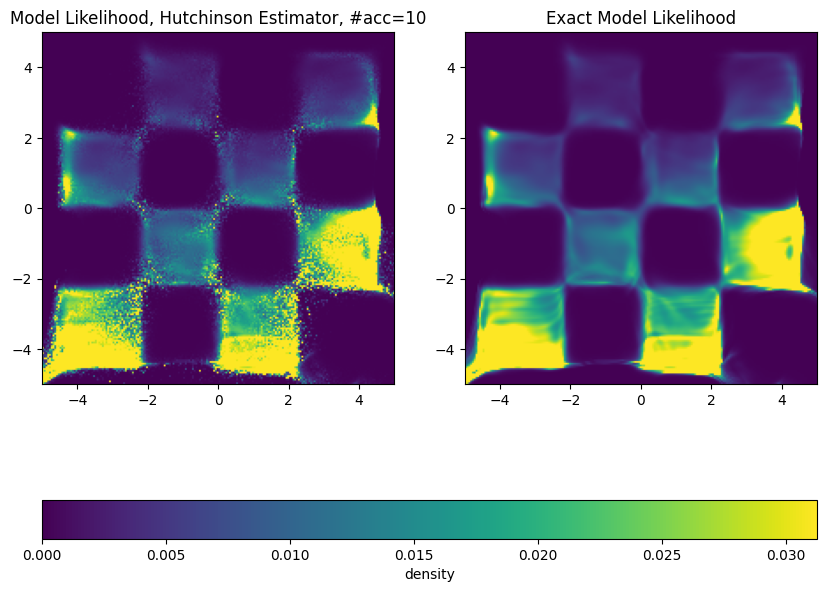

In [50]:
likelihood = torch.exp(log_p_acc).cpu().reshape(grid_size, grid_size).detach().numpy()
exact_likelihood = torch.exp(exact_log_p).cpu().reshape(grid_size, grid_size).detach().numpy()

fig, axs = plt.subplots(1, 2,figsize=(10,10))

cmin = 0.0
cmax = 1/32 # 1/32 is the gt likelihood value

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

axs[0].imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[0].set_title('Model Likelihood, Hutchinson Estimator, #acc=%d' % num_acc)

axs[1].imshow(exact_likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[1].set_title('Exact Model Likelihood')

fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axs, orientation='horizontal', label='density')
plt.show()

[ 1.25863451  0.21072824  0.47653971 ... -1.05856967  0.70536014
  0.449306  ]


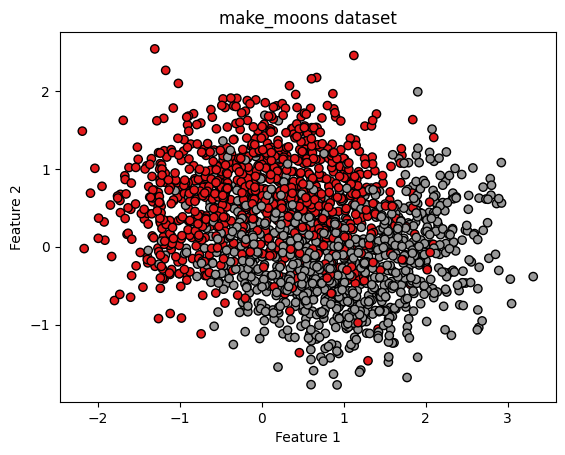

In [36]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=2000, noise=0.5, random_state=42)
print(X[:, 0])
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('make_moons dataset')
plt.show()

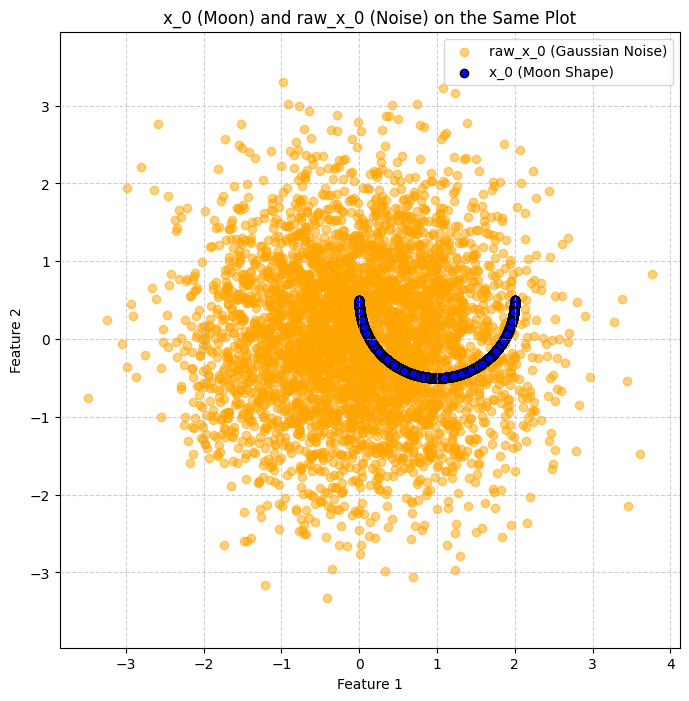

In [34]:
# Define a sample size for demonstration
# In your original code, this would be based on another tensor `x_1`
import numpy as np
n_samples_per_class = 4096

# 1. Generate the full make_moons dataset (both moons)
# We need twice the final sample count because we're only taking one moon
full_x, full_y = make_moons(n_samples=n_samples_per_class * 2, noise=0, random_state=42)

# 2. Select only one of the moons for x_0
# This line takes the first `n_samples_per_class` points belonging to class 0
x_0 = full_x[full_y == 1][:n_samples_per_class]

# 3. Generate the raw Gaussian noise data
raw_x_0 = np.random.randn(n_samples_per_class, 2)


# --- Plotting Both Datasets ---

# Create a figure and axes for the plot
plt.figure(figsize=(8, 8))

# Plot the Gaussian noise (raw_x_0) first as a background
# Using a lower alpha value makes the points semi-transparent
plt.scatter(raw_x_0[:, 0], raw_x_0[:, 1],
            color='orange',
            alpha=0.5,
            label='raw_x_0 (Gaussian Noise)')

# Plot the moon-shaped data (x_0) on top
plt.scatter(x_0[:, 0], x_0[:, 1],
            color='blue',
            edgecolor='k',
            label='x_0 (Moon Shape)')


# --- Final Touches ---
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('x_0 (Moon) and raw_x_0 (Noise) on the Same Plot')
plt.legend() # Display the labels
plt.axis('equal') # Ensure x and y axes have the same scale
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

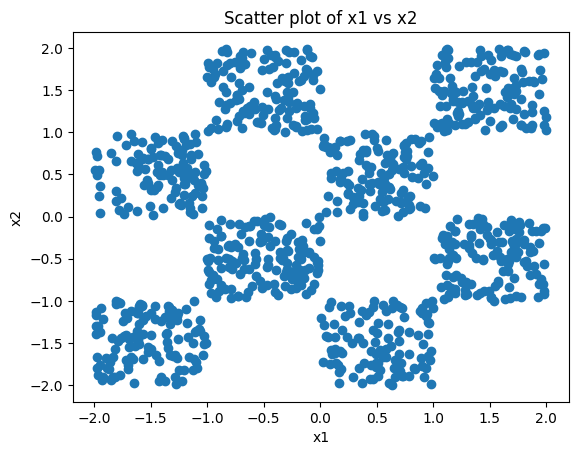

In [10]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x1 = torch.rand(1000, device=device) * 4 - 2
x2_ = torch.rand(1000, device=device) - torch.randint(high=2, size=(1000,), device=device) * 2
x2 = x2_ + (torch.floor(x1) % 2)

data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45

plt.scatter(x1.cpu().numpy(), x2.cpu().numpy())
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter plot of x1 vs x2')
plt.show()